# TP de filtrage bayésien

Calcul de l'intégrale $\displaystyle \int_{0}^{1} cos(\frac{\pi x}{2}) \, \mathrm{d}x$ par simulation de Monte Carlo

In [25]:
import numpy as np
import numpy.random
import math
# !pip install matplotlib
import matplotlib.pyplot as plt
# !pip install scipy
from scipy.integrate import quad
import warnings

## Par MC brute

In [26]:
iterations_mc = 1000
taille_echantillon=50

def g(x):
    return(math.cos(math.pi*x/2))

def mu_n(taille_echantillon):
    """generation d'une réalisation de mu_n"""
    return({"valeur" : np.mean([g(np.random.uniform(0,1)) for i in range(taille_echantillon)]),"acceptation" : False})

def simulation_mu_n(iterations_mc,taille_echantillon,estimateur):
    """return un array de taille iterations_mc réalisations de mu_n"""
    estimation=[]
    proba_acceptation = []
    
    for i in range(iterations_mc):
        estimateur_value = estimateur(taille_echantillon)
        estimation.append(estimateur_value["valeur"])
        proba_acceptation.append(estimateur_value["acceptation"])
    return({"estimation" : np.array(estimation),"acceptation" : np.mean(np.array(proba_acceptation))})


In [27]:
monte_carlo_vector_1 = simulation_mu_n(iterations_mc,taille_echantillon,mu_n)["estimation"]
variance_emp_1 =  np.var(monte_carlo_vector_1)
variance_theo_1 = ((1/2-4/(math.pi)**2)/taille_echantillon)
print("variance empirique : "+str(variance_emp_1))
print("variance théorique : " + str(variance_theo_1))

variance empirique : 0.0018058110590551152
variance théorique : 0.001894305308612978


In [28]:
# monte_carlo_vector_1
2/math.pi

0.6366197723675814

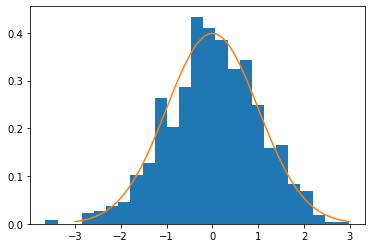

In [29]:
"""Comparaison à la loi normale par le TCL"""
import scipy.stats as stats
x = np.linspace(-3, 3, 100)

mu_theorique = 2/math.pi
plt.hist((monte_carlo_vector_1-mu_theorique)/(np.sqrt(variance_emp_1)), bins="auto", density=True)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.show()

## Par importance sampling

In [30]:
def developement_limite_2_g(x):
    """DL de g en 0 à l'ordre 2"""
    return(1 - ((math.pi*x)**2)/8 )

def developement_limite_2_adapte_g(x):
    """DL de g en 0 à l'ordre 2 corrigé"""
    return(((math.pi**2)/8)*(1-x**2))

def developement_limite_4_g(x):
    """DL de g en 0 à l'ordre 4"""
    return(1 - ((math.pi*(x-1))**2)/8 + ((math.pi*(x-1))**4)/48)

def q_tilde(x):
    """q_tilde"""
    facteur_normalisation, err = quad(developement_limite_2_adapte_g,0,1)
    return(developement_limite_2_adapte_g(x)/facteur_normalisation)

def q2_tilde(x):
    return(3*(1-x**2)/2)


Affichage de g et de son DL en 0

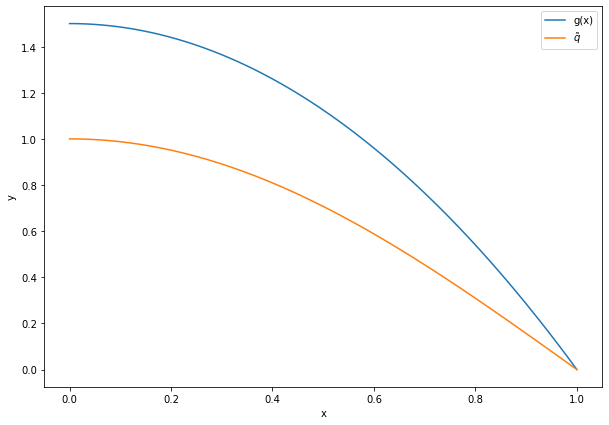

In [36]:
X = np.linspace(0,1,100)
DL= q2_tilde(X)
G = [g(x) for x in X]
plt.figure(figsize = (10,7))
plt.plot(X,DL)
plt.plot(X,G)
plt.legend(["g(x)","$\\tilde{q}$"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Affichage de $\overset{\sim}{q}$ donne :


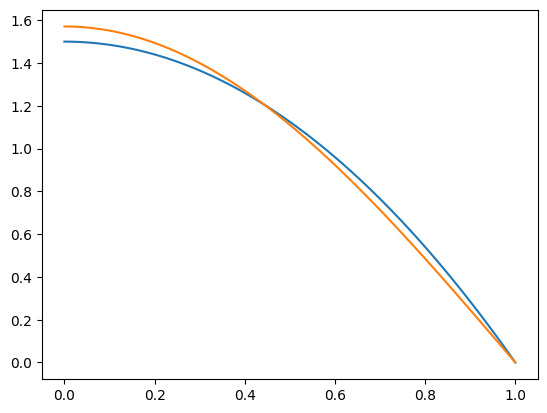

In [7]:
X = np.linspace(0,1,100)
Q= q_tilde(X)
G = [g(x)/mu_theorique for x in X]
# on normalise g avec la valeur exacte de l'intégrale de g*q pour être cohérent avec q_tilde

plt.plot(X,Q)
plt.plot(X,G)
plt.show()

In [38]:
def quotient_g_q(x,q_tilde):
    """quotient de g et q_tilde"""
    return(g(x)/q_tilde(x))

def mu_tilde_n(taille_echantillon,q_tilde):
    """generation d'une réalisation de mu_tilde_n"""
    méthode_rejet =  np.array([generation_q_tilde(q_tilde) for i in range(taille_echantillon)])
    quotient = [quotient_g_q(méthode_rejet[i,0],q_tilde) for i in range(taille_echantillon)]
    proba_acceptation = np.shape(méthode_rejet)[0]/np.sum(méthode_rejet[:,1])
    return({"valeur" : np.mean(quotient),"acceptation" : proba_acceptation})

def generateur_d_estimateur(q_tilde):
    """renvoie l'estimateur mu_tilde_n"""
    return(lambda x: mu_tilde_n(x,q_tilde))

def generation_q_tilde(q_tilde): 
    """genere une va distribuée selon la densité q_tilde, selon la méthode du rejet"""
    X = np.random.uniform(0,1,1)
    U = np.random.uniform(0,1,1)
    C= q_tilde(0)
    nombre_de_tentatives = 1
    while q_tilde(X)<C*U : 
        X = np.random.uniform(0,1,1)
        U = np.random.uniform(0,1,1)
        nombre_de_tentatives +=1
    return(X,nombre_de_tentatives)


Calcul de la variance empirique de $\hat{\mu}_{N}$ estimé par importance sampling avec le changement de probabilité
$\overset{\sim}{q}(x) = \frac{(1-\frac{\pi^{2}x^{2}}{8})}{   \displaystyle \int_{0}^{1} (1-\frac{\pi^{2}t^{2}}{8}) \, \mathrm{d}t }$

variance empirique importance sampling : 1.9356541506033443e-05
estimation de la probabilité d'acceptation : 0.6712953441350769
--------------
variance théorique : 1.9816618803727428e-05
Probabilité d'acceptation théorique : 0.6666666666666666


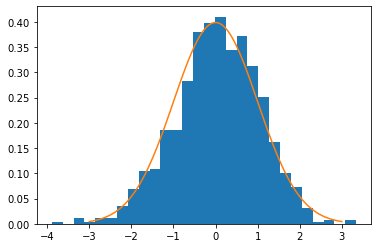

--------------
rapport des variances  empiriques des 2 méthodes : 0.010719029219015687
rapport des variances  theoriques des 2 méthodes : 0.010461153602656204


In [45]:
warnings.filterwarnings("ignore")

def integrande_var_theo(q_tilde):
        return(lambda x :g(x)*g(x)/q_tilde(x))
        
def importance_sampling(q_tilde) :
        simulation = simulation_mu_n(iterations_mc,taille_echantillon,generateur_d_estimateur(q_tilde))
        # print(simulation)
        estimateur = simulation["estimation"] ## monte_carlo_vector_2 = estimateur
        proba_acceptation = simulation["acceptation"]
        variance_emp_2 = np.var(estimateur)
        print("variance empirique importance sampling : " + str(variance_emp_2))
        print("estimation de la probabilité d'acceptation : "+ str(np.mean(proba_acceptation)))

        # variance theorique


        integrale,err = quad(integrande_var_theo(q_tilde),0,1)

        # calcul de la variance théorique
        variance_theo_2 = (integrale-4/((math.pi)**2))/taille_echantillon
        print("--------------")
        print("variance théorique : "+ str(variance_theo_2))

        #calcul de la probabilité d'acceptation
        print("Probabilité d'acceptation théorique : "+str(1/q_tilde(0)))

        #Comparaison de "importance sampling" à la loi normale par le TCL
        import scipy.stats as stats
        x = np.linspace(-3, 3, 100)
        mu_theorique = 2/math.pi
        plt.hist((estimateur-mu_theorique)/(np.sqrt(variance_emp_2)), bins="auto", density=True)
        plt.plot(x, stats.norm.pdf(x, 0, 1))
        plt.show()

        #comparaison des deux méthodes
        print("--------------")
        print("rapport des variances  empiriques des 2 méthodes : " +str(variance_emp_2/variance_emp_1) )
        print("rapport des variances  theoriques des 2 méthodes : " +str(variance_theo_2/variance_theo_1) )


        # comparer les budgets (jsp ce que c'est)

importance_sampling(q2_tilde)

## changement de probabilité du prof : prenons $\overset{\sim}{q}(x) = \frac32(1-x^2)$

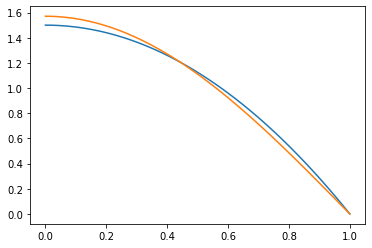

variance empirique importance sampling : 2.0851029280864277e-05
estimation de la probabilité d'acceptation : 0.6689810790822077
--------------
variance théorique : 1.9816618803727428e-05
Probabilité d'acceptation théorique : 0.6666666666666666


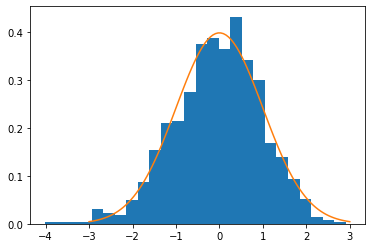

--------------
rapport des variances  empiriques des 2 méthodes : 0.011546628411819845
rapport des variances  theoriques des 2 méthodes : 0.010461153602656204


In [40]:
def q_tilde_prof(x):
    return(3/2*(1-x**2))

""" Affichage de q_tilde par rapport à gq """
X = np.linspace(0,1,100)
Q= q_tilde(X)
G = [g(x)/mu_theorique for x in X]
# on normalise g avec la valeur exacte de l'intégrale de g*q pour être cohérent avec q_tilde

plt.plot(X,Q)
plt.plot(X,G)
plt.show()

importance_sampling(q_tilde_prof)

## Autre changement de probabilité : prenons $\overset{\sim}{q}_{2}(x) = 2(1-x)$

In [11]:
def q_tilde_2(x):
    return(2*(1-x))

variance empirique importance sampling : 0.00012821599647684997
estimation de la probabilité d'acceptation : 0.5062460538481511
--------------
variance théorique : 0.00013569350213551656
Probabilité d'acceptation théorique : 0.5


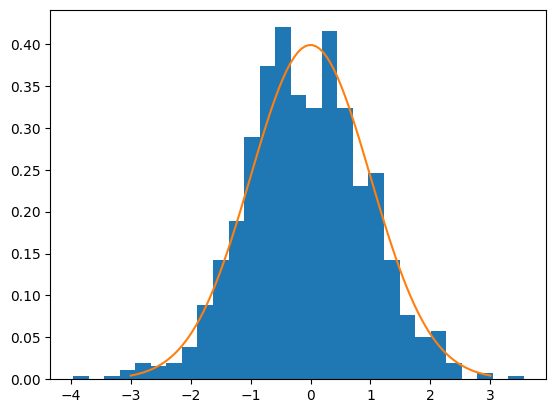

--------------
rapport des variances  empiriques des 2 méthodes : 0.06967438279713285
rapport des variances  theoriques des 2 méthodes : 0.07163232955033641


In [12]:
importance_sampling(q_tilde_2)

Autre changement de probabilité : prenons $\overset{\sim}{q}_{1}(x) = g(x)$

variance empirique importance sampling : 0.0
estimation de la probabilité d'acceptation : 0.6382051022273846
--------------
variance théorique : 0.004626700755964605
Probabilité d'acceptation théorique : 1.0


ValueError: supplied range of [inf, inf] is not finite

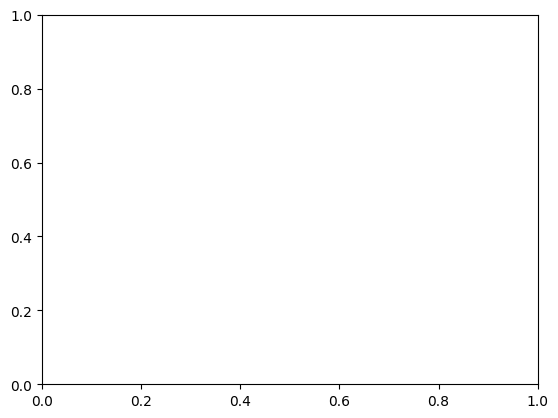

In [13]:
importance_sampling(g)
# normal que ça marche pas : histogramme = dirac

# Verification du TCL

 Dans cette section, on estime $\mu_{N}$ un nombre $M=1000$ de fois, puis on trace l'histogramme de $\sqrt{N}(\frac{\mu_{N} - \mu}{\sigma})$ 

### Pour l'estimation "naive" de $\mu_{N}$

(array([  7.,  22.,  89., 169., 235., 237., 135.,  86.,  15.,   5.]),
 array([-3.11334795, -2.47435326, -1.83535857, -1.19636388, -0.55736919,
         0.08162551,  0.7206202 ,  1.35961489,  1.99860958,  2.63760427,
         3.27659896]),
 <BarContainer object of 10 artists>)

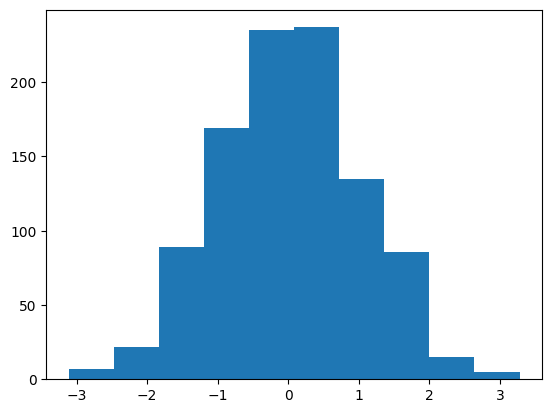

In [14]:
mu = 2/math.pi
sigma = np.sqrt((1/2-4/(math.pi)**2))
simulation = simulation_mu_n(iterations_mc,taille_echantillon,mu_n)["estimation"]
normalisation = np.sqrt(taille_echantillon)*(simulation-mu)/sigma
plt.hist(normalisation)


## Avec echantillonage préférentiel 

(array([  5.,  13.,  38., 106., 182., 251., 197., 136.,  58.,  14.]),
 array([-3.38851733, -2.78582811, -2.18313889, -1.58044968, -0.97776046,
        -0.37507124,  0.22761798,  0.8303072 ,  1.43299641,  2.03568563,
         2.63837485]),
 <BarContainer object of 10 artists>)

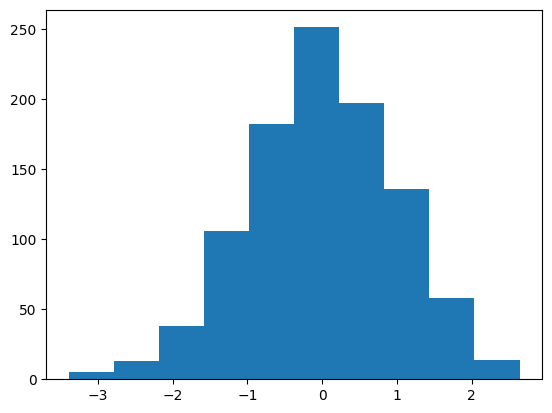

In [15]:
mu = 2/math.pi
integrale,err = quad(integrande_var_theo(q_tilde),0,1)
sigma = np.sqrt(integrale-4/((math.pi)**2))
simulation = simulation_mu_n(iterations_mc,taille_echantillon,generateur_d_estimateur(q_tilde))["estimation"]
normalisation = np.sqrt(taille_echantillon)*(simulation-mu)/sigma
plt.hist(normalisation)

In [48]:
def integrande(x):
    return(math.cos(math.pi*x/2)*(1-x**2))
integrale = quad(integrande,0,1)
print(integrale)

(0.5160245509311918, 5.729023377156659e-15)
